In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import os
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sns

In [ ]:
results = pd.read_csv('/Users/orestisbastas/Developer/bio2d_public/results/ames_catboost_single_feature.csv')

In [125]:
# Standardize features
scaler = StandardScaler()
def standardize(X):
    return scaler.fit_transform(X)

# PCA & t-SNE Visualization with Subplots
def plot_pca_tsne(X, ax1, ax2, ax3, ax4, spatial_distance, spatial_distance_max):
    X_scaled = standardize(X)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_title('PCA')

    # cumulative explained variance
    pca = PCA()
    pca.fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    ax2.set_xlabel('Number of Principal Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    percent_at_90 = ( np.argmax(cumulative_variance >= 0.9) + 1 ) / len(cumulative_variance)
    ax2.set_title(f'PCA Cumulative Explained Variance - Features at 90% variance: {percent_at_90:.2f}')
    ax2.grid(True)
    
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.5)
    ax3.set_title('t-SNE')

    '''
    If deep embeddings have lower skewness than fingerprints, they might distribute more evenly in feature space.
    If deep embeddings have higher positive skewness, they may collapse into tight clusters, potentially causing overfitting.

    High positive skewness → Many close points, some far → Possible overfitting / redundancy
    Low or negative skewness → More even spread → Potentially better representation
    If embeddings have too high or too low skewness, fine-tuning may help improve their representation quality.
    '''
    skewness = np.mean((spatial_distance - spatial_distance.mean()) ** 3) / (spatial_distance.std() ** 3)

    ax4.set_xlim(0, spatial_distance_max)
    sns.kdeplot(spatial_distance.flatten(), ax=ax4, fill=True, color='blue', alpha=0.5, )
    ax4.set_xlabel('Distance')
    ax4.set_ylabel('Density')
    ax4.set_title(f'Spatial distance - Mean: {spatial_distance.mean():.2f}, Std: {spatial_distance.std():.2f}, Skewness: {skewness:.2f}')

    # 


# Feature Variance Analysis
def analyze_variance(X):
    X_scaled = standardize(X)
    selector = VarianceThreshold()
    X_selected = selector.fit_transform(X_scaled)
    retained_features = X_selected.shape[1]
    return f'Low information fetures {X.shape[1] - retained_features}/{X.shape[1]}'

In [99]:
deep_learning_features = ['bartsmiles.csv', 'molformer.csv', 'megamolbart.csv', 'mol2vec.csv', 'grover.csv']

In [7]:
datasets_location = "/Users/orestisbastas/Developer/bio2d_public/data"
datasets = os.listdir(f"{datasets_location}/")

['erg.csv', 'avalon.csv', 'rdkit_fp.csv', 'megamolbart.csv', 'rdkit_desc.csv', 'grover.csv', 'ecfp4.csv', 'molformer.csv', 'atom_pair.csv', 'autocorr_2d.csv', 'mol2vec.csv', 'mordred.csv', 'bartsmiles.csv', 'maccs_keys.csv']


/opt/homebrew/anaconda3/envs/b2d/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/envs/b2d/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/envs/b2d/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/envs/b2d/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/envs/b2d/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnin

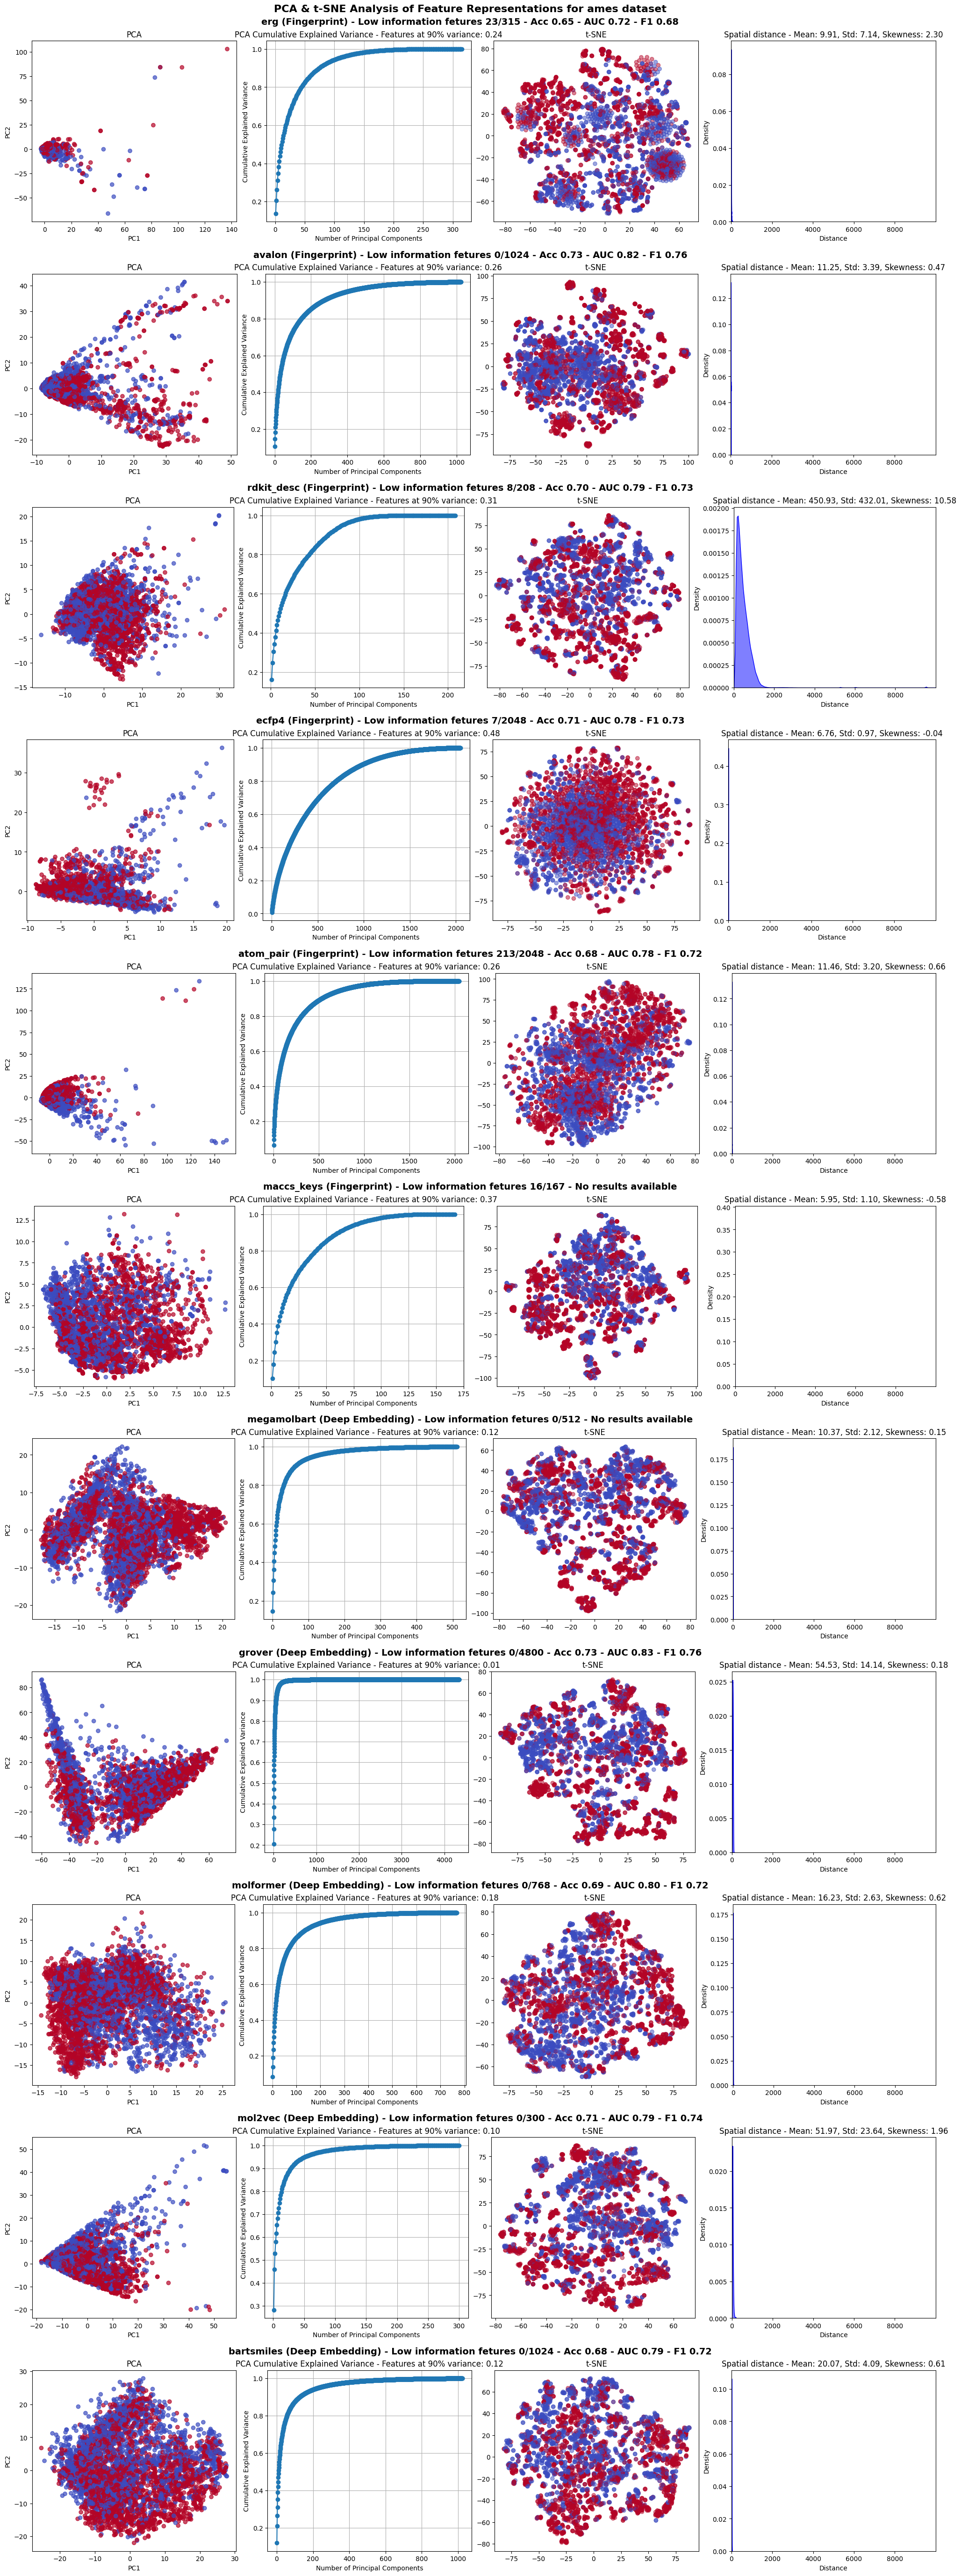

In [ ]:
for dataset in sorted(datasets):
    if dataset.startswith("."):
        continue

    train_features = os.listdir(f'{datasets_location}/{dataset}/features/train/')

    fingerprints = {}
    deep_embeddings = {}
    spatial_distances = {}
    spatial_distance_max = 0
    y = None

    for train_feature in train_features:
        if 'rdkit_fp' in train_feature or 'autocorr_2d' in train_feature or 'mordred' in train_feature:
            continue
        feature_csv = pd.read_csv(f'{datasets_location}/{dataset}/features/train/{train_feature}')
        label = feature_csv['value']
        if y is None:
            y = label.values

        # drop any column that doesn't have the train_feature prefix in the column name
        feature_csv = feature_csv.drop(columns=[col for col in feature_csv.columns if train_feature.split('.')[0] not in col])
        # get the features by combining every row as a numpy array
        features = feature_csv.values
    
        spatial_distance = distance_matrix(features, features)
        spatial_distance = spatial_distance.flatten()
        if spatial_distance.max() > spatial_distance_max:
            spatial_distance_max = spatial_distance.max()
        spatial_distances[train_feature] = spatial_distance

        if train_feature in deep_learning_features:
            deep_embeddings[train_feature] = features
        else:
            fingerprints[train_feature] = features

    all_features = {**fingerprints, **deep_embeddings}
    num_rows = len(all_features)
    fig = plt.figure(constrained_layout=True, figsize=(20, 5 * num_rows))
    fig.suptitle(f'PCA & t-SNE Analysis of Feature Representations for {dataset} dataset', fontsize=16, fontweight='bold')

    # Create subfigures
    subfigs = fig.subfigures(nrows=num_rows, ncols=1)
    for row, (name, X) in enumerate(all_features.items()):
        if name.split('.')[0] in results['feature_type'].unique():
            result = results[results['feature_type'] == name.split('.')[0]].iloc[0]
            results_string = f'Acc {result["acc_val"]:.2f} - AUC {result["auprc_val"]:.2f} - F1 {result["f1_val"]:.2f}'
        else:
            results_string = "No results available"
            
        sd = spatial_distances[name]
        feature_type = "Fingerprint" if name in fingerprints else "Deep Embedding"
        variance_info = analyze_variance(X)
        row_title = f'{name.split(".csv")[0]} ({feature_type}) - {variance_info} - {results_string}'
        subfigs[row].suptitle(row_title, fontsize=14, fontweight='bold')
        
        axs = subfigs[row].subplots(nrows=1, ncols=4)
        plot_pca_tsne(X, axs[0], axs[1], axs[2], axs[3], sd, spatial_distance_max)

    plt.show()

    break

